In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
import torchaudio
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from scr import preprocessor
plt.style.use("ggplot")

# Speech Classification Pipeline
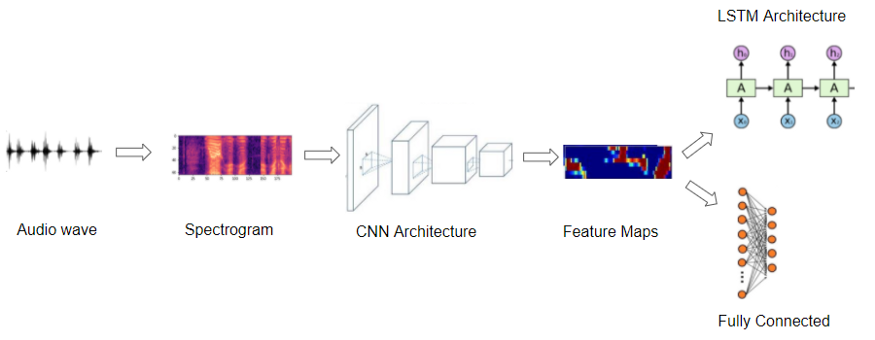

source: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

## Data exploration

Let's explore some meta information from one sample from each class.

bangla
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


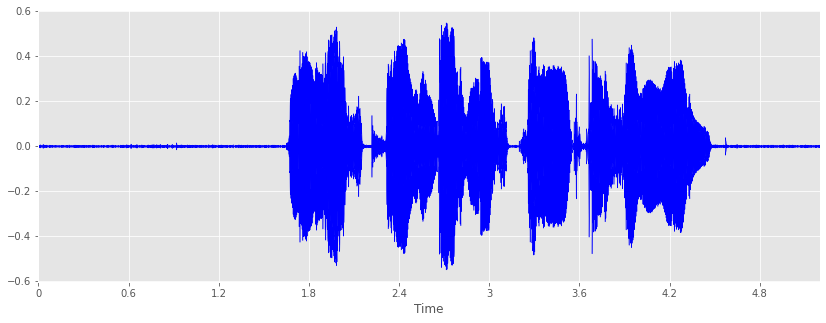

british
AudioMetaData(sample_rate=22050, num_frames=79380, num_channels=1, bits_per_sample=16, encoding=PCM_S)


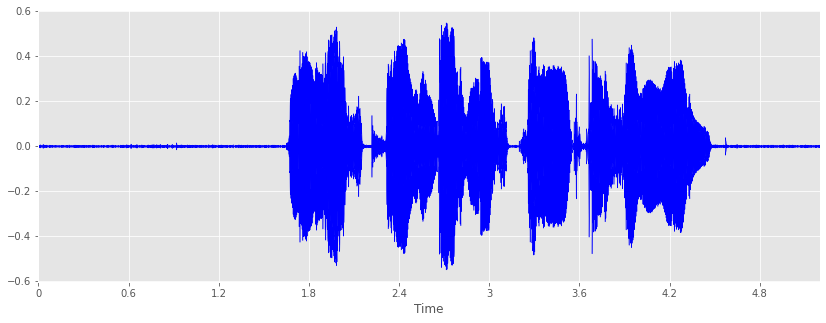

odiya
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


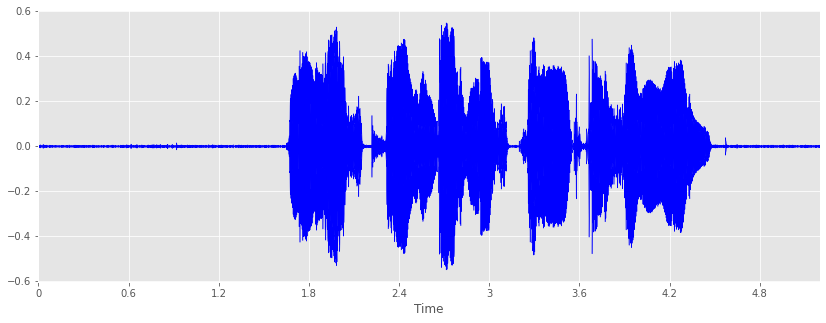

telugu
AudioMetaData(sample_rate=48000, num_frames=230400, num_channels=2, bits_per_sample=16, encoding=PCM_S)


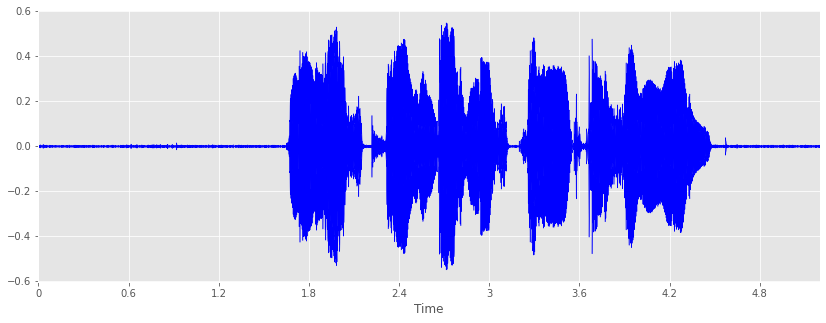

indian
AudioMetaData(sample_rate=22050, num_frames=88200, num_channels=1, bits_per_sample=16, encoding=PCM_S)


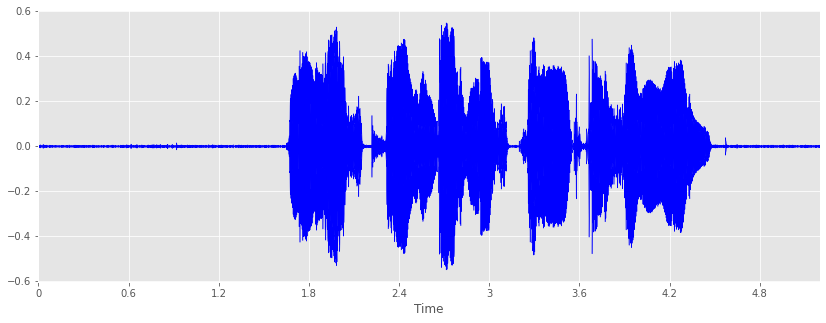

american
AudioMetaData(sample_rate=22050, num_frames=66150, num_channels=1, bits_per_sample=16, encoding=PCM_S)


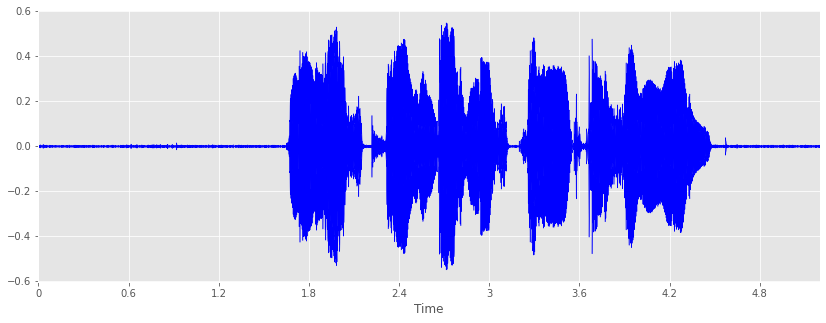

australian
AudioMetaData(sample_rate=22050, num_frames=74970, num_channels=1, bits_per_sample=16, encoding=PCM_S)


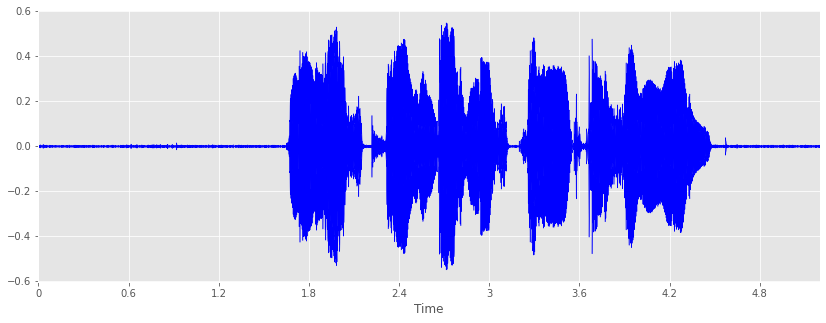

welsh
AudioMetaData(sample_rate=22050, num_frames=83790, num_channels=1, bits_per_sample=16, encoding=PCM_S)


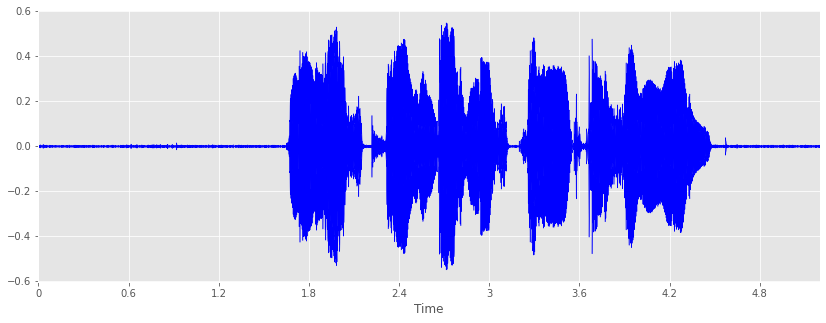

malayalam
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


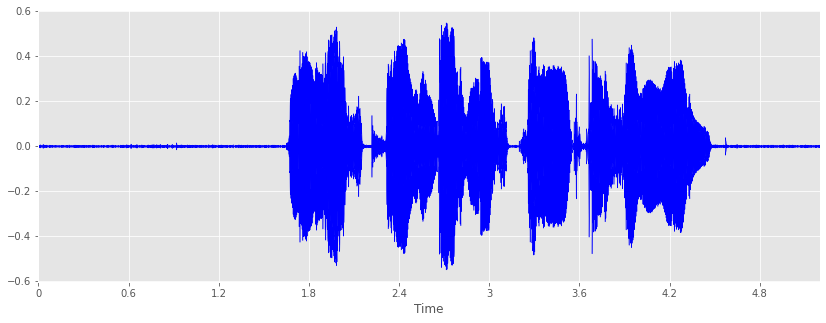

In [2]:
accents_path = "./accentdb_extended/data"

for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/" + accent_dir + "/"
    print(accent_dir)
    for file in os.listdir(dir_path):
        file_path = dir_path + file
        print(torchaudio.info(file_path))
        x, sr = librosa.load("./accentdb_extended/data/bangla/bangla_s01_115.wav")
        plt.figure(figsize=(14, 5))
        librosa.display.waveplot(x, sr=sr, color="b")
        plt.show()
        break

As we can see, some sound files are mono -- 1 audio channel, and some are stereos -- 2 audio channels. Since the classification model expects all items to have the exact dimensions, we can convert the mono files to stereo by duplicating the first channel to the second.
Also, some sound files are sampled at a sample rate of 48000 Hz, and the others at a rate of 22050 Hz. It means that 1 second of audio will have an array size of 48000 for some sound files, while it will have a smaller array size of 22050 for the others. We can see that from the difference in the number of frames. Therefore, we must standardize and convert all audio to the same sampling rate so that all arrays have the exact dimensions.

In [3]:
# create a dataframe for further usage
rows = []
for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/" + accent_dir + "/"
    for file in os.listdir(dir_path):
        rows.append(["/" + accent_dir + "/" + file, i, accent_dir])

df = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])
df

,file_path,class_id,class_name
0,/bangla/bangla_s01_115.wav,0,bangla
1,/bangla/bangla_s01_572.wav,0,bangla
2,/bangla/bangla_s01_057.wav,0,bangla
3,/bangla/bangla_s01_481.wav,0,bangla
4,/bangla/bangla_s01_413.wav,0,bangla
...,...,...,...
6677,/malayalam/malayalam_s01_562.wav,8,malayalam
6678,/malayalam/malayalam_s01_184.wav,8,malayalam
6679,/malayalam/malayalam_s01_514.wav,8,malayalam
6680,/malayalam/malayalam_s01_439.wav,8,malayalam


## Data preprocessing

In [4]:
class SpeechDataset(Dataset):
    def __init__(self, data_fr, data_path):
        self.data_fr = data_fr
        self.data_path = str(data_path)

    def __len__(self):
        return len(self.data_fr)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.data_fr.loc[idx, "file_path"]
        class_id = self.data_fr.loc[idx, "class_id"]
        aud = preprocessor.load_audio(audio_file)
        rechannel = preprocessor.double_channel(aud)
        downsampl = preprocessor.downsample(rechannel)
        timed = preprocessor.append_trunc(downsampl)
        specgram = preprocessor.spectro_mfcc(timed)
        return specgram, class_id

In [5]:
myds = SpeechDataset(df, accents_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=11, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=11, shuffle=False)

In [6]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

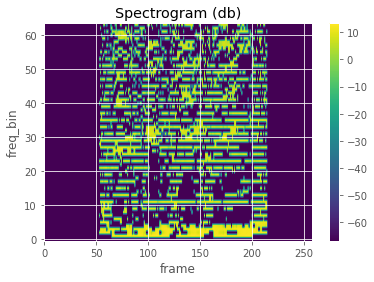

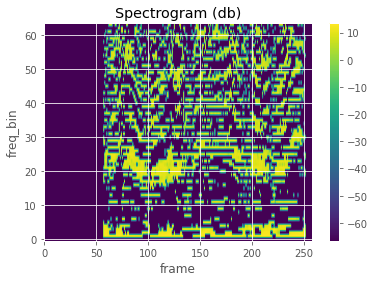

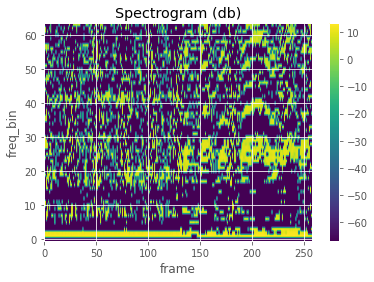

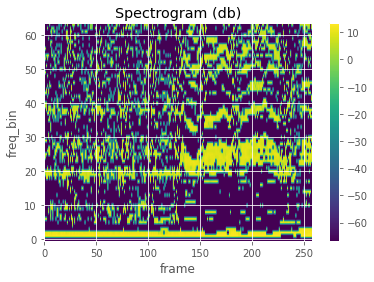

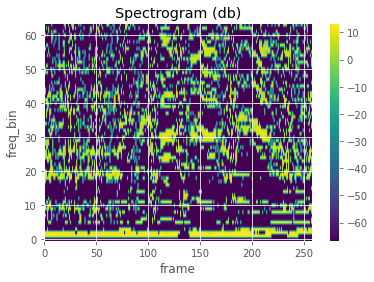

In [7]:
for i in range(5):
    plot_spectrogram(train_ds[i][0][0])

## Classifier model

In [8]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        pl.seed_everything(42)
        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=32, out_features=9)
        self.dropout = nn.Dropout(0.4)

    def forward(self, inp_x):
        inp_x = self.conv(inp_x)
        inp_x = self.ap(inp_x)
        inp_x = inp_x.view(inp_x.shape[0], -1)
        inp_x = self.dropout(inp_x)
        inp_x= self.lin(inp_x)
        return inp_x


# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cpu")
model = model.to(device)
next(model.parameters()).device

Global seed set to 42


device(type='cpu')

In [9]:

# metric
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()

    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        self.total += y_true.size(0)

    def compute(self):
        return self.correct / self.total

    def reset(self):
        self.correct = 0
        self.total = 0

## Training the classifier

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 5
# training loop
train_loss_history = []
train_accuracy_history = []

valid_loss_history = []
valid_accuracy_history = []

accuracy = AccuracyMetric()

for epoch in range(1, epochs + 1):
    print(f"[INFO] Epoch: {epoch}")
    model.train()

    batch_train_loss = []
    batch_valid_loss = []

    for X_batch, y_batch in tqdm(train_dl):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_predicted = model(X_batch)

        loss = criterion(y_predicted, y_batch)
        loss.backward()
        optimizer.step()


        accuracy.update(y_predicted, y_batch)
        batch_train_loss.append(loss.item())

    mean_epoch_loss_train = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()

    train_loss_history.append(mean_epoch_loss_train)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_predicted = model(X_batch)

            loss_val = criterion(y_predicted, y_batch)

            accuracy.update(y_predicted, y_batch)
            batch_valid_loss.append(loss_val.item())

    mean_epoch_loss_valid = np.mean(batch_valid_loss)
    valid_accuracy = accuracy.compute()

    valid_loss_history.append(mean_epoch_loss_valid)
    valid_accuracy_history.append(valid_accuracy)
    accuracy.reset()

    print(
        f"Train loss: {mean_epoch_loss_train:0.4f}, Train accuracy: {train_accuracy: 0.4f}"
    )
    print(
        f"Validation loss: {mean_epoch_loss_valid:0.4f}, Validation accuracy: {valid_accuracy: 0.4f}"
    )

  0%|          | 1/486 [00:00<01:31,  5.29it/s]

[INFO] Epoch: 1


  0%|          | 1/486 [00:00<01:08,  7.11it/s]

Train loss: 1.1815, Train accuracy:  0.5600
Validation loss: 0.4971, Validation accuracy:  0.8960
[INFO] Epoch: 2


  0%|          | 1/486 [00:00<01:10,  6.90it/s]

Train loss: 0.4716, Train accuracy:  0.8567
Validation loss: 0.2015, Validation accuracy:  0.9551
[INFO] Epoch: 3


  0%|          | 1/486 [00:00<01:15,  6.43it/s]

Train loss: 0.2662, Train accuracy:  0.9299
Validation loss: 0.1299, Validation accuracy:  0.9573
[INFO] Epoch: 4


  0%|          | 0/486 [00:00<?, ?it/s]

Train loss: 0.1811, Train accuracy:  0.9512
Validation loss: 0.3039, Validation accuracy:  0.8743
[INFO] Epoch: 5


100%|██████████| 122/122 [00:14<00:00,  8.13it/s]

Train loss: 0.1604, Train accuracy:  0.9588
Validation loss: 0.0945, Validation accuracy:  0.9723
